In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory


In [ ]:
(train_images,train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.map(lambda x,y: (tf.image.resize(x,IMG_SIZE),y))
train_ds = train_ds.batch(BATCH_SIZE)

In [ ]:
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.map(lambda x,y: (tf.image.resize(x,IMG_SIZE),y))
test_ds = test_ds.batch(BATCH_SIZE)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
#validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)


In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(10,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy
(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=test_ds)

Epoch 1/10
1563/1563 [==============================] - 1194s 764ms/step - loss: 2.0829 - accuracy: 0.4111 - val_loss: 1.9220 - val_accuracy: 0.5785
Epoch 2/10
1563/1563 [==============================] - 1192s 762ms/step - loss: 1.9345 - accuracy: 0.5635 - val_loss: 1.8129 - val_accuracy: 0.6822
Epoch 3/10
1172/1563 [=====================>........] - ETA: 4:12 - loss: 1.8987 - accuracy: 0.5928

In [ ]:
model.save('MV2_CIFAR_10.h5')

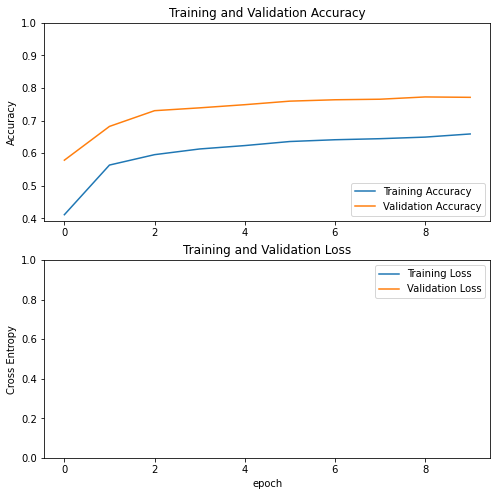

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 10
initial_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=test_ds)

Epoch 10/20
1563/1563 [==============================] - 1879s 1s/step - loss: 1.7686 - accuracy: 0.6943 - val_loss: 1.6730 - val_accuracy: 0.7916
Epoch 11/20
1563/1563 [==============================] - 1893s 1s/step - loss: 1.7309 - accuracy: 0.7315 - val_loss: 1.6371 - val_accuracy: 0.8264
Epoch 12/20
1563/1563 [==============================] - 1897s 1s/step - loss: 1.7088 - accuracy: 0.7524 - val_loss: 1.6622 - val_accuracy: 0.8008
Epoch 13/20
1563/1563 [==============================] - 1896s 1s/step - loss: 1.6920 - accuracy: 0.7696 - val_loss: 1.6196 - val_accuracy: 0.8429
Epoch 14/20
1563/1563 [==============================] - 1916s 1s/step - loss: 1.6804 - accuracy: 0.7810 - val_loss: 1.6245 - val_accuracy: 0.8373
Epoch 15/20
1563/1563 [==============================] - 1899s 1s/step - loss: 1.6726 - accuracy: 0.7886 - val_loss: 1.6217 - val_accuracy: 0.8407
Epoch 16/20
1563/1563 [==============================] - 1919s 1s/step - loss: 1.6634 - accuracy: 0.7979 - val_loss: 1

In [ ]:
model.save('MV2_CIFAR10.h5')

NameError: ignored

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

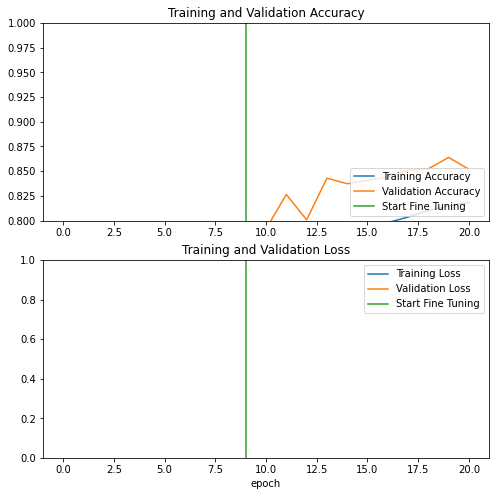

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# New section

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(10,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=test_ds)

Epoch 1/10
1563/1563 [==============================] - 1793s 1s/step - loss: 2.0370 - accuracy: 0.5253 - val_loss: 1.8245 - val_accuracy: 0.7442
Epoch 2/10
1563/1563 [==============================] - 1794s 1s/step - loss: 1.8741 - accuracy: 0.6571 - val_loss: 1.7423 - val_accuracy: 0.7846
Epoch 3/10
1563/1563 [==============================] - 1798s 1s/step - loss: 1.8307 - accuracy: 0.6843 - val_loss: 1.7087 - val_accuracy: 0.8014
Epoch 4/10
1563/1563 [==============================] - 1801s 1s/step - loss: 1.8083 - accuracy: 0.7000 - val_loss: 1.6904 - val_accuracy: 0.8094
Epoch 5/10
1563/1563 [==============================] - 1807s 1s/step - loss: 1.7930 - accuracy: 0.7090 - val_loss: 1.6796 - val_accuracy: 0.8125
Epoch 6/10
1563/1563 [==============================] - 1811s 1s/step - loss: 1.7832 - accuracy: 0.7148 - val_loss: 1.6717 - val_accuracy: 0.8176
Epoch 7/10
1563/1563 [==============================] - 1809s 1s/step - loss: 1.7757 - accuracy: 0.7200 - val_loss: 1.6652 -

In [ ]:
model.save('Effb0_cifar10.h5')

In [ ]:
model = tf.keras.models.load_model('Effb0_cifar10.h5')

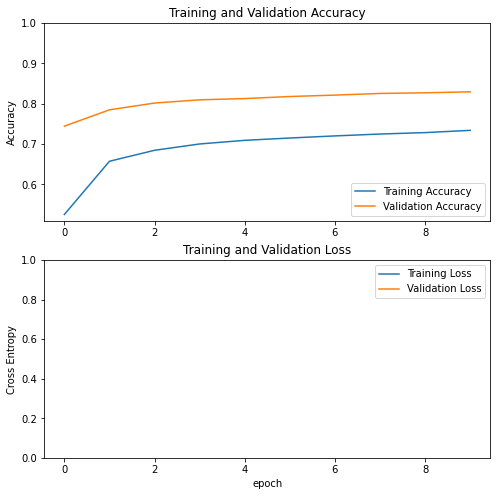

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 5, 5, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_______________________________________

In [ ]:
base_model = model.layers[2]
base_model.trainable

True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  237


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 10
initial_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=test_ds)

Epoch 10/20
1563/1563 [==============================] - 1814s 1s/step - loss: 1.7550 - accuracy: 0.7356 - val_loss: 1.6531 - val_accuracy: 0.8295
Epoch 11/20
1563/1563 [==============================] - 1813s 1s/step - loss: 1.7552 - accuracy: 0.7327 - val_loss: 1.6528 - val_accuracy: 0.8290
Epoch 12/20
1563/1563 [==============================] - 1815s 1s/step - loss: 1.7540 - accuracy: 0.7365 - val_loss: 1.6526 - val_accuracy: 0.8291
Epoch 13/20
1563/1563 [==============================] - 1813s 1s/step - loss: 1.7542 - accuracy: 0.7358 - val_loss: 1.6525 - val_accuracy: 0.8295
Epoch 14/20
1563/1563 [==============================] - 1812s 1s/step - loss: 1.7536 - accuracy: 0.7360 - val_loss: 1.6522 - val_accuracy: 0.8292
Epoch 15/20
1563/1563 [==============================] - 1821s 1s/step - loss: 1.7540 - accuracy: 0.7351 - val_loss: 1.6519 - val_accuracy: 0.8303
Epoch 16/20
1563/1563 [==============================] - 1818s 1s/step - loss: 1.7544 - accuracy: 0.7346 - val_loss: 1

In [ ]:
model.save('Eff_CIFAR_10.h5')